In [91]:
from scipy.io import loadmat
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

gaussian = loadmat('gaussian.mat')
#print(banana)


# Extract the variables
class_num = gaussian['class_num']
data = gaussian['data']
label = gaussian['label']

# Convert variables to DataFrames
class_num_df = pd.DataFrame(class_num, columns=['class_num'])
data_df = pd.DataFrame(data, columns=['feature1', 'feature2'])
true_labels = pd.DataFrame(label, columns=['label'])

# Concatenate the DataFrames horizontally
df = pd.concat([class_num_df, data_df, true_labels], axis=1)

# Perform Min-Max scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['feature1', 'feature2']])

# Update the scaled data in the DataFrame
df['feature1'] = scaled_data[:, 0]
df['feature2'] = scaled_data[:, 1]
data = df[['feature1', 'feature2']].values
print(data)

[[0.2290785  0.88967196]
 [0.15035587 0.5651841 ]
 [0.3169924  0.68003238]
 ...
 [0.23756187 0.3298687 ]
 [0.65462472 0.20014433]
 [0.19177955 0.79026535]]


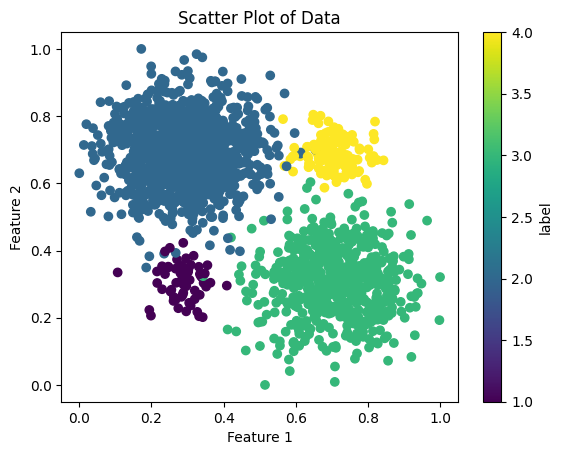

In [93]:
import matplotlib.pyplot as plt

# Plot the data
plt.scatter(df['feature1'], df['feature2'], c=label, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Data')
plt.colorbar(label='label')
plt.show()

In [94]:
import math

def oghlidos_fasele(p1, p2):
    return math.sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(p1, p2)))


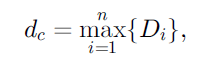

In [95]:
distances = []

import numpy as np
my_distance = []
distances = []

for i in range(len(data)):
    min_distance = np.inf
    for j in range(len(data)):
        if i != j:
            distance = oghlidos_fasele(data[i] , data[j])

            if distance < min_distance:
                min_distance = distance
    distances.append(min_distance)

# Calculate the maximum distance, dc
dc = max(distances)
print(dc)

0.08048418598251203


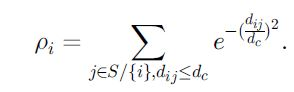

In [97]:

def calculate_density(dataset, dc):
    n = len(dataset)
    densities = []

    for i in range(n):
        sigma =0
       # di_min = float('inf')  # Initialize with a large value
        for j in range(n):
          dij = oghlidos_fasele(dataset[i] , dataset[j])
          if i!=j and dij <= dc :


              sigma += math.exp(-((dij/dc)**2))

                  # Calculate the Euclidean distance
        densities.append(sigma)


    return densities






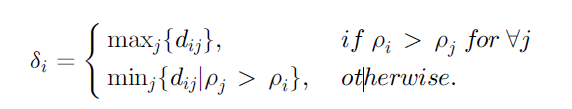

In [98]:
from tqdm import tqdm
def upward_distances(dataset, densities):
    n = len(dataset)
    distances = np.zeros(n)

    for i in tqdm(range(n)):
        if densities[i] == np.max(densities):
          distances[i] = np.max([oghlidos_fasele(dataset[i], dataset[j]) for j in range(n) ])
        else :
          min_distance = np.inf
          for j in range(n):
            if (densities[j] > densities[i]) and (i != j):
                distance = oghlidos_fasele(dataset[i], dataset[j])
                min_distance = min(min_distance, distance)
          distances[i] = min_distance

    return distances

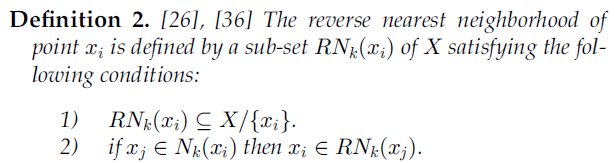

In [99]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

def calculate_reverse_nearest_neighbors(data, k):
    n = len(data)
    RNN = []

    # Create k-NN model
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the model with the data
    knn.fit(data, range(n))

    # Get the k nearest neighbors for each point
    _, indices = knn.kneighbors(data)

    # Store the reverse nearest neighbors
    for i in range(n):
        RNNi = [j for j in range(n) if i in indices[j] and j != i]

        RNN.append(RNNi)
    rnn_count = [len(RNNi) for RNNi in RNN]

    return rnn_count


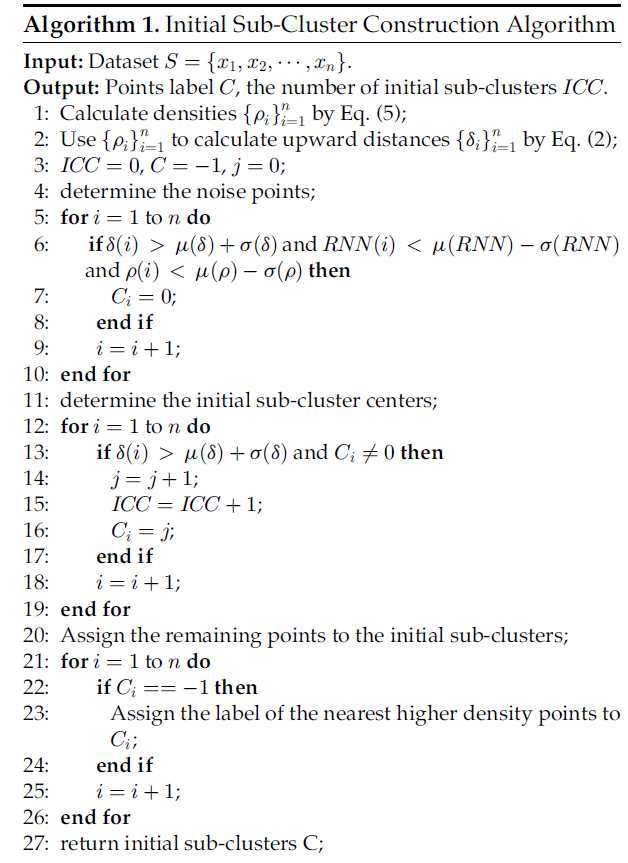

In [101]:
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

######### algo1
n = len(data)
C_values = -np.ones(n)  # ci = -1
ICC = 0
j = 0

densities = calculate_density(data, dc)  # 1

distances = upward_distances(data, densities)  # 2

RNN = calculate_reverse_nearest_neighbors(data, 10)  # 3

mean_density = np.mean(densities)
std_density = np.std(densities)

mean_upward = np.mean(distances)
std_upward = np.std(distances)

mean_RNN = np.mean(RNN)
std_RNN = np.std(RNN)
print(mean_RNN)
print(std_upward)

for i in tqdm(range(len(data))):  # determine noise
    data_i = data[i]
    density_i = densities[i]
    upward_i = distances[i]
    RNNi = RNN[i]

    if (density_i < mean_density - std_density) and (upward_i > mean_upward + std_upward) and (RNNi < mean_RNN - std_RNN):
        C_values[i] = 0


cluster_centers = []
for i in range(len(data)):  # determine subcluster centers

    data_i = data[i]
    density_i = densities[i]
    upward_i = distances[i]

    if upward_i > (mean_upward + std_upward) and C_values[i] != 0:

        j = j + 1
        ICC = ICC + 1
        C_values[i] = j

        cluster_centers.append( (i , ICC) )


distances = [] # store and sort distances for each point i asceding
for i in range(len(data)):
    distances_i = []
    for j in range(len(data)):
        if i != j:
            distance = oghlidos_fasele(data[i], data[j])
            distances_i.append((j, distance))
    distances_i.sort(key=lambda x: x[1])  # Sort distances by ascending order
    distances.append(distances_i)

for i in range(len(data)):  # Assign remaining points to subclusters
    if C_values[i] == -1:
      for idx, distance in distances[i]:
        if C_values[idx] != -1 and C_values[idx] !=0 :
          if densities[idx] > densities[i]:
              C_values[i] = C_values[idx]
              break





100%|██████████| 2000/2000 [00:09<00:00, 208.66it/s]


9.0
0.023683464886795715


100%|██████████| 2000/2000 [00:00<00:00, 452655.30it/s]


In [102]:
print(C_values)

[ 2.  2.  2. ...  3. 10.  2.]


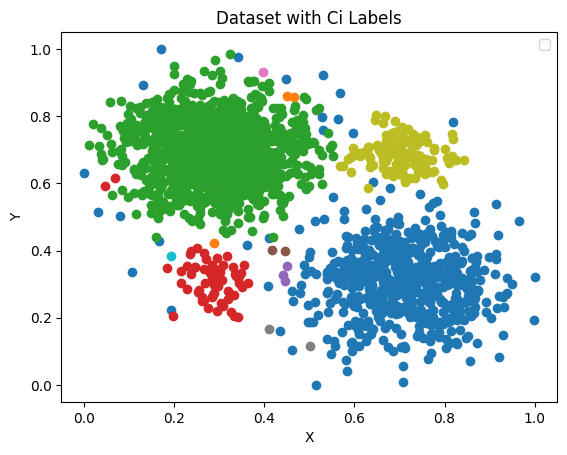

In [103]:
import matplotlib.pyplot as plt

def plot_dataset(data, Ci):
    unique_labels = np.unique(Ci)

    for label in unique_labels:
        x = data[Ci == label, 0]  # Assuming x-coordinates are in the first column of data
        y = data[Ci == label, 1]  # Assuming y-coordinates are in the second column of data
        plt.scatter(x, y)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Dataset with Ci Labels")
    plt.legend()
    plt.show()


plot_dataset(data, C_values)


In [104]:
cluster_counts = {}
for ci in C_values:
    if ci != -1:
        if ci in cluster_counts:
            cluster_counts[ci] += 1
        else:
            cluster_counts[ci] = 1

for ci, count in cluster_counts.items():
    print(f"Cluster {ci}: {count} points")

Cluster 2.0: 1179 points
Cluster 0.0: 44 points
Cluster 10.0: 577 points
Cluster 8.0: 123 points
Cluster 4.0: 3 points
Cluster 3.0: 61 points
Cluster 7.0: 2 points
Cluster 1.0: 1 points
Cluster 5.0: 2 points
Cluster 13.0: 2 points
Cluster 6.0: 1 points
Cluster 12.0: 2 points
Cluster 11.0: 2 points
Cluster 9.0: 1 points


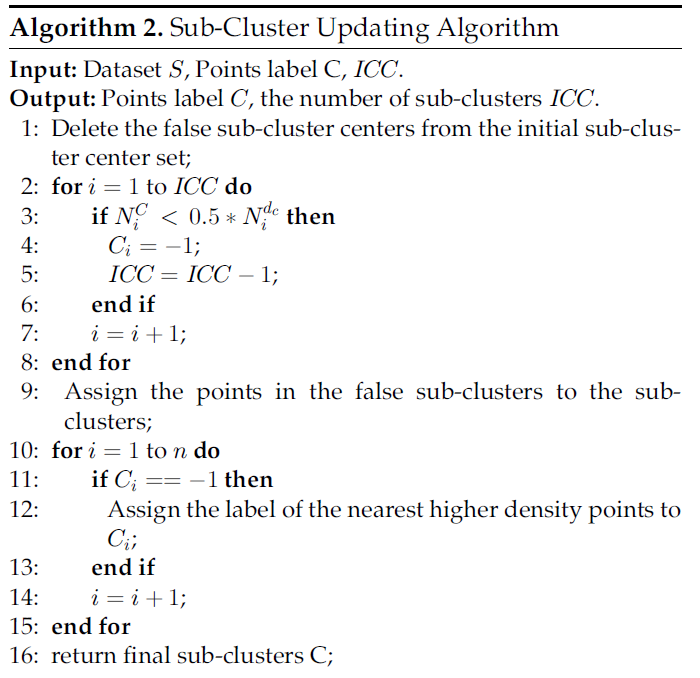

In [106]:
#### Delete the false sub-cluster centers from the initial sub-cluster center set
new_cluster_centers = []
for i in range(1 , ICC + 1 ) :

  points_in_dc_radius = 0

  points = [idx for idx, ci_value in enumerate(C_values) if ci_value == i]  # Find points belonging to the current subcluster
  new_cluster_centers.append(cluster_centers[i-1])
  print(data[((cluster_centers[i-1])[0])])
  Nc = len(points)
  cluster_center = data[ (cluster_centers[i-1])[0] ]

  points_in_dc_radius = [idx for idx, point in enumerate(data) if oghlidos_fasele(cluster_center, point) <= dc]  # Find points within radius dc from the center
  Ndc =  len(points_in_dc_radius)

  if Nc < 0.5 * Ndc :
    new_cluster_centers.remove(cluster_centers[i-1])

    for point_idx in points:
            C_values[point_idx] = -1
    ICC = ICC -1



#### Assign the points in the false sub-clusters to the subclusters

for i in range(len(data)):
    if C_values[i] == -1:
      for idx, distance in distances[i]:
        if C_values[idx] != -1 and C_values[idx] !=0 :
          if densities[idx] > densities[i]:
              C_values[i] = C_values[idx]
              break






[0.2881566  0.42288352]
[0.30888308 0.68559069]
[0.29052413 0.31114841]
[0.44978447 0.35329097]
[0.4452457  0.39788986]
[0.39786261 0.93256262]
[0.50073247 0.11583744]
[0.70716662 0.69053175]
[0.19418448 0.38280617]
[0.69540093 0.33592285]
[0.45036728 0.86001608]
[0.37311081 0.45896018]
[0.06905152 0.61691807]


In [108]:
cluster_counts = {}
for ci in C_values:
    if ci != -1:
        if ci in cluster_counts:
            cluster_counts[ci] += 1
        else:
            cluster_counts[ci] = 1

for ci, count in cluster_counts.items():
    print(f"Cluster {ci}: {count} points")

Cluster 2.0: 1186 points
Cluster 0.0: 44 points
Cluster 10.0: 582 points
Cluster 8.0: 123 points
Cluster 3.0: 65 points


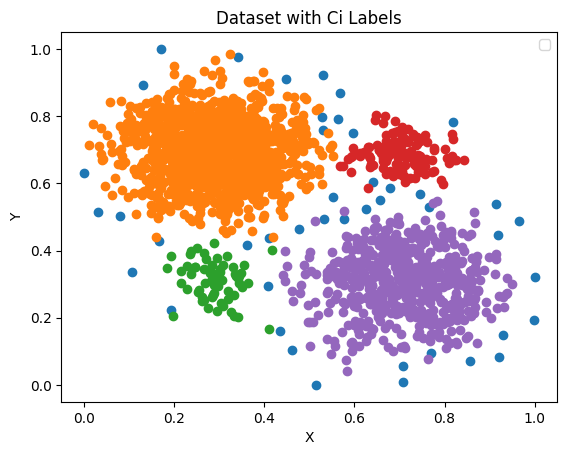

In [109]:
import matplotlib.pyplot as plt

def plot_dataset(data, Ci):
    unique_labels = np.unique(Ci)

    for label in unique_labels:
        x = data[Ci == label, 0]  # Assuming x-coordinates are in the first column of data
        y = data[Ci == label, 1]  # Assuming y-coordinates are in the second column of data
        plt.scatter(x, y)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Dataset with Ci Labels")
    plt.legend()
    plt.show()

# Assuming you have your dataset `data` and Ci labels `C_values` available
plot_dataset(data, C_values)

In [110]:
print(new_cluster_centers)

[(355, 2), (469, 3), (1453, 8), (1660, 10)]


In [111]:
def find_min_distance_between_clusters(cluster1, cluster2):
    min_distance = np.inf
    for point1 in cluster1:

        for point2 in cluster2:
            distance = oghlidos_fasele(data[point1], data[point2] )  # Calculate the distance between the two points
            if distance < min_distance:
                pi = point1
                pj = point2
                min_distance = distance
    return min_distance , pi , pj

In [112]:
def calculate_merging_radius( data , dc , C_values):
    noise_points = [idx for idx, ci_value in enumerate(C_values) if ci_value == 0]  # Find the indices of noise points

    if len(noise_points) == 0:
        merging_radius = dc  # If no noise points, merging radius equals dc
    else:
        min_distances = []
        for i in range(len(data)):
            if i not in noise_points:
                min_distance = np.inf
                for j in range(len(data)):
                    if j != i and j not in noise_points:
                        distance = oghlidos_fasele(data[i], data[j])  # Calculate the distance between points
                        if distance < min_distance:
                            min_distance = distance
                min_distances.append(min_distance)

        merging_radius = max(min_distances)  # Find the maximum minimum distance

    return merging_radius


In [113]:
def calculate_boundary_points(data, C_values, densities, ICC):
    boundary_points = []

    # Find the boundary points
    for ci in range(1, ICC + 1):
        label = (new_cluster_centers[ci-1])[1]
        cluster_points = [idx for idx, ci_value in enumerate(C_values) if ci_value == label]  # Find points belonging to the current subcluster
        average_density = np.mean([densities[idx] for idx in cluster_points])  # Calculate the average density of the subcluster
        boundary_points.extend([idx for idx in cluster_points if densities[idx] < average_density])  # Find the boundary points based on density

    return boundary_points

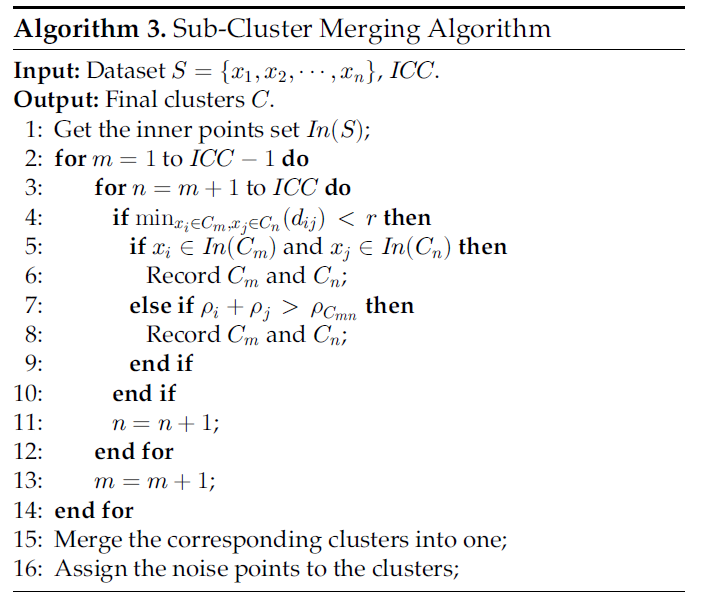

In [114]:
cluster_record = []
boundary_points = calculate_boundary_points(data, C_values, densities, ICC )
# Calculate inner points (subset In(X))
inner_points = [idx for idx in range(len(data)) if idx not in boundary_points]


for m in range ( 1 , ICC) :

  label_m = (new_cluster_centers[m-1])[1]

  n = m+1

  while n <= ICC :

    label_n = new_cluster_centers[n-1][1]

    cluster_m_points = [idx for idx, ci_value in enumerate(C_values) if ci_value == label_m]  # Find points in subcluster Cm
    cluster_n_points = [idx for idx, ci_value in enumerate(C_values) if ci_value == label_n]  # Find points in subcluster Cn

    density_Cm = densities[ ( new_cluster_centers[m - 1][0] ) ]
    density_Cn = densities[ ( new_cluster_centers[n - 1][0] ) ]
    density_Cmn = (density_Cm + density_Cn )  / 2

    min_dis , i_index , j_index = find_min_distance_between_clusters( cluster_m_points , cluster_n_points )
    r = calculate_merging_radius(data , dc , C_values)



    if min_dis < r :

          if (i_index in inner_points) and (j_index in inner_points):

            if (label_m , label_n) not in cluster_record :
               cluster_record.append((label_m, label_n))


          elif (densities[i_index] + densities[j_index]) > density_Cmn:

            if (label_m , label_n) not in cluster_record :
               cluster_record.append((label_m, label_n))
    n += 1






In [115]:
print(cluster_record)

[]


In [116]:
# Merge the corresponding clusters into one
for cluster_m, cluster_n in cluster_record:
    for idx, ci_value in enumerate(C_values):
        if ci_value == cluster_n:
            C_values[idx] = cluster_m

In [117]:
# Assign the noise points to the nearest clusters
for idx, ci_value in enumerate(C_values):
    if ci_value == 0:
        noise_point = data[idx]
        min_distance = np.inf
        nearest_cluster = -1

        for data_idx, data_point in enumerate(data):
            if data_idx != idx and C_values[data_idx] != 0:
                distance = oghlidos_fasele(noise_point, data_point)
                if distance < min_distance:
                    min_distance = distance
                    nearest_cluster = C_values[data_idx]

        C_values[idx] = nearest_cluster


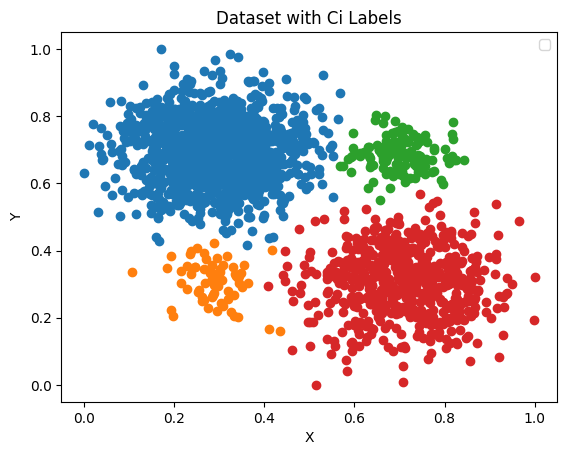

In [118]:
import matplotlib.pyplot as plt

def plot_dataset(data, Ci):
    unique_labels = np.unique(Ci)

    for label in unique_labels:
        x = data[Ci == label, 0]  # Assuming x-coordinates are in the first column of data
        y = data[Ci == label, 1]  # Assuming y-coordinates are in the second column of data
        plt.scatter(x, y)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Dataset with Ci Labels")
    plt.legend()
    plt.show()

# Assuming you have your dataset `data` and Ci labels `C_values` available
plot_dataset(data, C_values)

In [119]:
cluster_counts = {}
for ci in C_values:
    if ci != -1:
        if ci in cluster_counts:
            cluster_counts[ci] += 1
        else:
            cluster_counts[ci] = 1

for ci, count in cluster_counts.items():
    print(f"Cluster {ci}: {count} points")

Cluster 2.0: 1202 points
Cluster 3.0: 68 points
Cluster 10.0: 602 points
Cluster 8.0: 128 points


In [120]:
new_values = pd.DataFrame()
new_label = []
# Assign new labels to specific values in C_values
new_labels = []
for idx, ci_value in enumerate(C_values):

    if ci_value == 3:

        new_label = 1
        new_labels.append(new_label)
    elif ci_value == 10:
        new_label = 3
        new_labels.append(new_label)
    elif ci_value == 8:
        new_label = 4
        new_labels.append(new_label)
    elif ci_value == 2:
        new_label = 2
        new_labels.append(new_label)
    else:
        new_labels.append(ci_value)

print(len(new_labels))
df_new_labels = pd.DataFrame({'new_labels': new_labels})
display(df_new_labels)

2000


,new_labels
0,2
1,2
2,2
3,1
4,2
...,...
1995,2
1996,2
1997,1
1998,3


In [121]:
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics.cluster import normalized_mutual_info_score

# Flatten the true_labels and new_labels
new_label = df_new_labels["new_labels"].values.flatten()
true_label = true_labels["label"].values.flatten()

# Calculate accuracy
accuracy = accuracy_score(true_label, new_label)

# Calculate recall
recall = recall_score(true_label, new_label, average='macro')

# Calculate normalized mutual information score
nmi = normalized_mutual_info_score(true_label, new_label)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Normalized Mutual Information Score:", nmi)

Accuracy: 0.9895
Recall: 0.9884724873381525
Normalized Mutual Information Score: 0.9373872077355536
